In [14]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Input, AveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import utils
from keras.callbacks import EarlyStopping
import tensorflow as tf
from focal_loss import BinaryFocalLoss
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, shutil

In [15]:
image_size = (512, 512)

#Create a Pandas dataframe for training data for exploratory data analysis
df = pd.read_csv(r'../images/trainLabels.csv')
df

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [16]:
#Total rows of data in our dataframe (-1 due to first row consisting of column headers)
print("Columns: ", len(df.columns), "- Rows: ", len(df.index))

Columns:  2 - Rows:  35126


In [17]:
#Check for any duplicated rows or null values
print(f"There are {df.duplicated().sum()} repeated rows")
print(df.isnull().sum())

There are 0 repeated rows
image    0
level    0
dtype: int64


[Text(0, 0, '25810'),
 Text(0, 0, '2443'),
 Text(0, 0, '5292'),
 Text(0, 0, '873'),
 Text(0, 0, '708')]

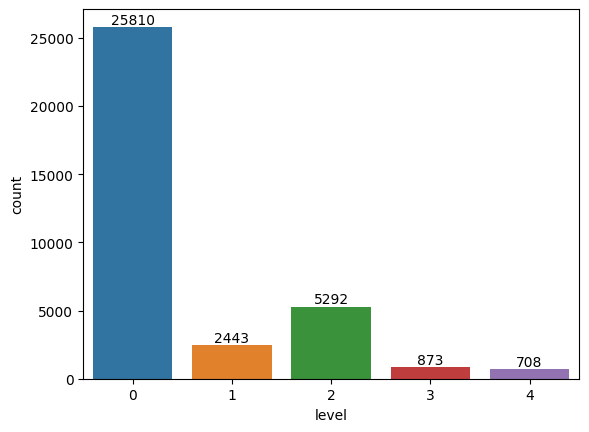

In [18]:
#Visualisation of quantity of images related to their grade of retinopathy
#We'll need to perform data augmentation as there is very low amount of images for each grade in comparison to clean images. 
distribution = sns.countplot(x=df['level'])
distribution.bar_label(distribution.containers[0])

In [19]:
base_dir = '../images/train'
test_dir = '../images/test'

#Make new directories for each retinopathy grade


grade_0_dir = os.path.join(base_dir, '0')
#os.mkdir(grade_0_dir)

grade_1_dir = os.path.join(base_dir, '1')
#os.mkdir(grade_1_dir)

grade_2_dir = os.path.join(base_dir, '2')
#os.mkdir(grade_2_dir)

grade_3_dir = os.path.join(base_dir, '3')
#os.mkdir(grade_3_dir)

grade_4_dir = os.path.join(base_dir, '4')
#os.mkdir(grade_4_dir)



In [20]:
#Move images from our main training folder and categorise into new folders
"""
for index, row in df.iterrows():
    shutil.move(f"../images/train/{row['image']}.jpeg", f"../images/train/{row['level']}/{row['image']}.jpeg")
"""

'\nfor index, row in df.iterrows():\n    shutil.move(f"../images/train/{row[\'image\']}.jpeg", f"../images/train/{row[\'level\']}/{row[\'image\']}.jpeg")\n'

In [21]:
#Due to the bias in image count, we are going to only use a maximum of 500 imgaes for each count before augmentation

balanced = os.path.join(base_dir, 'Balanced')
os.mkdir(balanced)

#Move first 500 images from the grade 0 folder
balanced_grade_0 = os.path.join(balanced, 'Balanced 0')
os.mkdir(balanced_grade_0)
dir = os.listdir(grade_0_dir)
images = [file for file in dir]

counter = 0

for img in images:
    if counter == 500:
        break
    
    src = os.path.join(grade_0_dir, img)
    dst = os.path.join(balanced_grade_0, img)
    shutil.move(src, dst)

    counter += 1

#Move first 500 images from the grade 1 folder

balanced_grade_1 = os.path.join(balanced, 'Balanced 1')
os.mkdir(balanced_grade_1)
dir = os.listdir(grade_1_dir)
images = [file for file in dir]

counter = 0

for img in images:
    if counter == 500:
        break
    
    src = os.path.join(grade_1_dir, img)
    dst = os.path.join(balanced_grade_1, img)
    shutil.move(src, dst)

    counter += 1


#Move first 500 images from the grade 2 folder

balanced_grade_2 = os.path.join(balanced, 'Balanced 2')
os.mkdir(balanced_grade_2)
dir = os.listdir(grade_2_dir)
images = [file for file in dir]

counter = 0

for img in images:
    if counter == 500:
        break
    
    src = os.path.join(grade_2_dir, img)
    dst = os.path.join(balanced_grade_2, img)
    shutil.move(src, dst)

    counter += 1


#Move first 500 images from the grade 3 folder

balanced_grade_3 = os.path.join(balanced, 'Balanced 3')
os.mkdir(balanced_grade_3)
dir = os.listdir(grade_3_dir)
images = [file for file in dir]

counter = 0

for img in images:
    if counter == 500:
        break
    
    src = os.path.join(grade_3_dir, img)
    dst = os.path.join(balanced_grade_3, img)
    shutil.move(src, dst)

    counter += 1

#Move first 500 images from the grade 4 folder

balanced_grade_4 = os.path.join(balanced, 'Balanced 4')
os.mkdir(balanced_grade_4)
dir = os.listdir(grade_4_dir)
images = [file for file in dir]

counter = 0

for img in images:
    if counter == 500:
        break
    
    src = os.path.join(grade_4_dir, img)
    dst = os.path.join(balanced_grade_4, img)
    shutil.move(src, dst)

    counter += 1


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../images/train\\Balanced'

In [22]:
train_ds = utils.image_dataset_from_directory(
    balanced,
    labels="inferred",
    label_mode='int',
    color_mode='rgb',
    batch_size=42,
    image_size=image_size,
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='training',
    crop_to_aspect_ratio=True
)

test_ds = utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=42,
    image_size=image_size,
    shuffle=True,
    seed=32,
    crop_to_aspect_ratio=True
)

validation_ds = utils.image_dataset_from_directory(
    balanced,
    labels="inferred",
    label_mode='int',
    color_mode='rgb',
    batch_size=42,
    image_size=image_size,
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='validation',
    crop_to_aspect_ratio=True
)

Found 2500 files belonging to 5 classes.
Using 2000 files for training.
Found 53571 files belonging to 1 classes.
Found 2500 files belonging to 5 classes.
Using 500 files for validation.


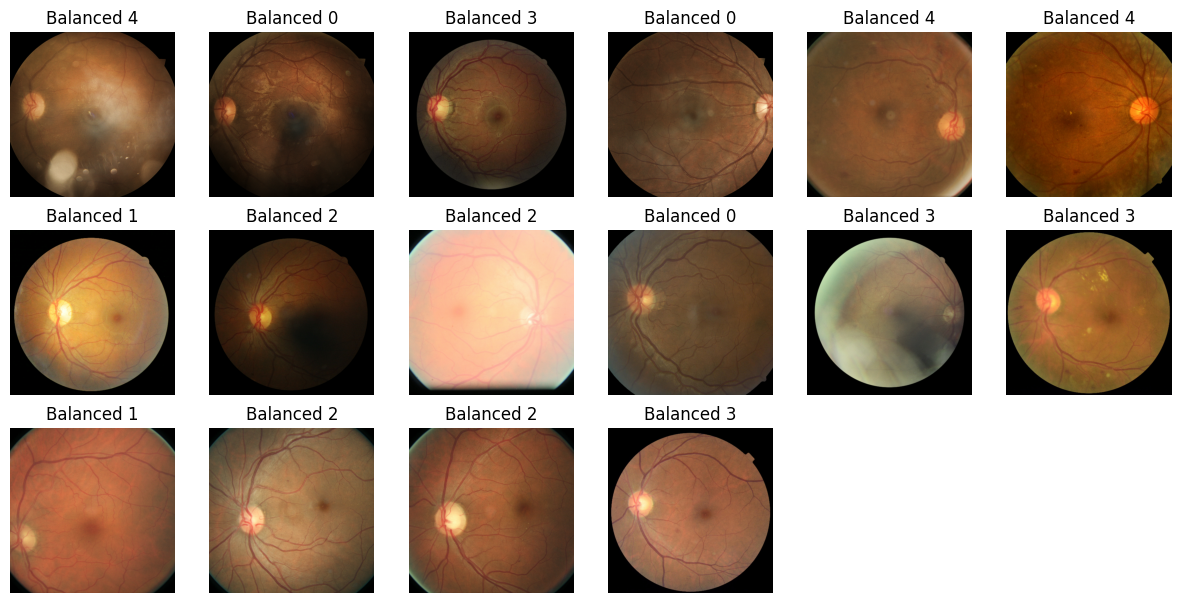

In [10]:
#Display a random set of images
plt.figure(figsize=(15, 15))

classes = train_ds.class_names

#Random 16 images from the training dataset
for images, labels in train_ds.take(1):
    for i in range(16):
        plot = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i] / 255)
        plt.title(classes[labels[i]])
        plt.axis('off')
        

In [23]:
#Due to reducing image count for balance, we will augment our images to generate a larger dataset. 
train_datagen = ImageDataGenerator(
    #rotation_range=30,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    horizontal_flip=True, #Dataset isn't standardised (i.e eye can be flipped either way) so our augment should match this as well
    rescale=1./255,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    balanced,
    target_size=image_size,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

valid_gen = train_datagen.flow_from_directory(
    balanced,
    target_size=image_size,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 2000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [24]:
adam = Adam()
earlystop = EarlyStopping(monitor='val_acc', patience=5)

#Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

In [13]:
history = model.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=[earlystop])

Epoch 1/75
63/63 [==============================] - 193s 3s/step - loss: 1.6113 - acc: 0.1925 - val_loss: 1.6095 - val_acc: 0.2000
Epoch 2/75
63/63 [==============================] - 117s 2s/step - loss: 1.6096 - acc: 0.1885 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 3/75
63/63 [==============================] - 114s 2s/step - loss: 1.6096 - acc: 0.1840 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 4/75
63/63 [==============================] - 110s 2s/step - loss: 1.6096 - acc: 0.1980 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 5/75
63/63 [==============================] - 116s 2s/step - loss: 1.6096 - acc: 0.1925 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 6/75
63/63 [==============================] - 118s 2s/step - loss: 1.6096 - acc: 0.1855 - val_loss: 1.6094 - val_acc: 0.2000


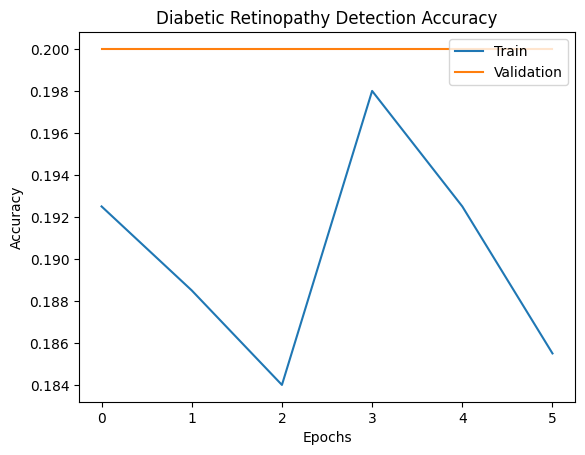

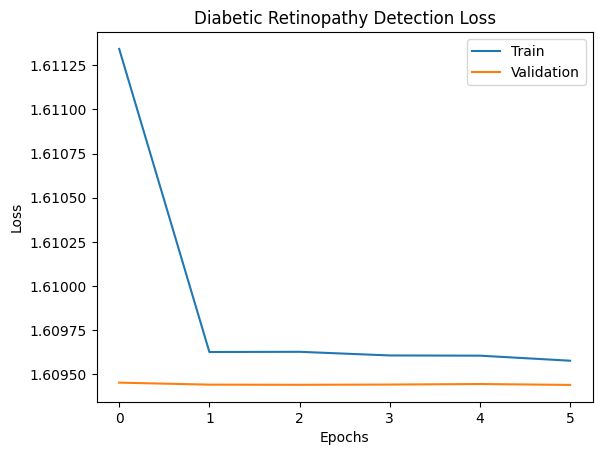

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 255, 255, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 126, 126, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 62, 62, 64)      

In [19]:
history = model.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=[earlystop])

Epoch 1/75
63/63 [==============================] - 117s 2s/step - loss: 1.9908 - acc: 0.2010 - val_loss: 1.6098 - val_acc: 0.2000
Epoch 2/75
63/63 [==============================] - 111s 2s/step - loss: 1.6101 - acc: 0.1845 - val_loss: 1.6095 - val_acc: 0.2000
Epoch 3/75
63/63 [==============================] - 114s 2s/step - loss: 1.6099 - acc: 0.1865 - val_loss: 1.6095 - val_acc: 0.2000
Epoch 4/75
63/63 [==============================] - 112s 2s/step - loss: 1.6098 - acc: 0.1810 - val_loss: 1.6095 - val_acc: 0.2000
Epoch 5/75
63/63 [==============================] - 118s 2s/step - loss: 1.6097 - acc: 0.1975 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 6/75
63/63 [==============================] - 117s 2s/step - loss: 1.6098 - acc: 0.1880 - val_loss: 1.6094 - val_acc: 0.2000


In [35]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 510, 510, 128)     3584      
                                                                 
 conv2d_112 (Conv2D)         (None, 508, 508, 128)     147584    
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 254, 254, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 252, 252, 64)      73792     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 126, 126, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 126, 126, 32)    

In [25]:
history = model.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=[earlystop])

Epoch 1/75


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_7/conv2d_53/Relu' defined at (most recent call last):
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\duliu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\duliu\AppData\Local\Temp\ipykernel_1628\771453830.py", line 1, in <module>
      history = model.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=[earlystop])
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\duliu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_7/conv2d_53/Relu'
OOM when allocating tensor with shape[32,256,510,510] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_7/conv2d_53/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12403]

VGG16:

In [32]:
from keras.applications import VGG16

base = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(512, 512, 3)))
base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [47]:
newHead = base.output
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dense(128, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(5, activation='softmax')(newHead)

vgg = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)
            
vgg.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [48]:
vgghistory = vgg.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 120s 2s/step - loss: 1.5656 - acc: 0.2995 - val_loss: 1.4092 - val_acc: 0.3600
Epoch 2/75
63/63 [==============================] - 112s 2s/step - loss: 1.4039 - acc: 0.3700 - val_loss: 1.3833 - val_acc: 0.3840
Epoch 3/75
63/63 [==============================] - 108s 2s/step - loss: 1.3925 - acc: 0.3800 - val_loss: 1.3611 - val_acc: 0.4260
Epoch 4/75
63/63 [==============================] - 113s 2s/step - loss: 1.3273 - acc: 0.4095 - val_loss: 1.3234 - val_acc: 0.4000
Epoch 5/75
63/63 [==============================] - 112s 2s/step - loss: 1.3086 - acc: 0.4365 - val_loss: 1.3018 - val_acc: 0.4320
Epoch 6/75
63/63 [==============================] - 107s 2s/step - loss: 1.2756 - acc: 0.4270 - val_loss: 1.3222 - val_acc: 0.4060
Epoch 7/75
63/63 [==============================] - 110s 2s/step - loss: 1.2631 - acc: 0.4430 - val_loss: 1.3077 - val_acc: 0.4300
Epoch 8/75
63/63 [==============================] - 111s 2s/step - loss: 1.2368 - a

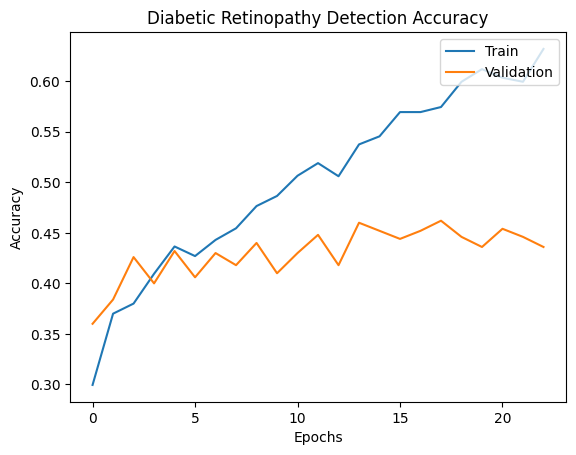

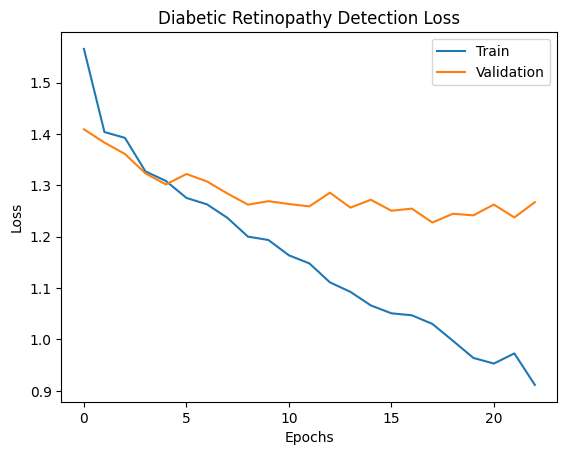

In [49]:
plt.plot(vgghistory.history['acc'])
plt.plot(vgghistory.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(vgghistory.history['loss'])
plt.plot(vgghistory.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Attempt at fine tuning by reducing image size to 224x224. This is the image size that VGG was based on.

In [29]:
newHead = base.output
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dense(256, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(128, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(64, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(5, activation='softmax')(newHead)

vgg = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)
            
vgg.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [30]:
vgghistory = vgg.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/15
125/125 [==============================] - 107s 848ms/step - loss: 1.7243 - acc: 0.2000 - val_loss: 1.6072 - val_acc: 0.2040
Epoch 2/15
125/125 [==============================] - 105s 839ms/step - loss: 1.6149 - acc: 0.2095 - val_loss: 1.6066 - val_acc: 0.2200
Epoch 3/15
125/125 [==============================] - 105s 837ms/step - loss: 1.6113 - acc: 0.2150 - val_loss: 1.6093 - val_acc: 0.2020
Epoch 4/15
125/125 [==============================] - 107s 853ms/step - loss: 1.6096 - acc: 0.2120 - val_loss: 1.6066 - val_acc: 0.2400
Epoch 5/15
125/125 [==============================] - 114s 911ms/step - loss: 1.6091 - acc: 0.1985 - val_loss: 1.6065 - val_acc: 0.2000
Epoch 6/15
125/125 [==============================] - 119s 946ms/step - loss: 1.6094 - acc: 0.1985 - val_loss: 1.6095 - val_acc: 0.1980
Epoch 7/15
125/125 [==============================] - 116s 925ms/step - loss: 1.6095 - acc: 0.1960 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 8/15
125/125 [============================

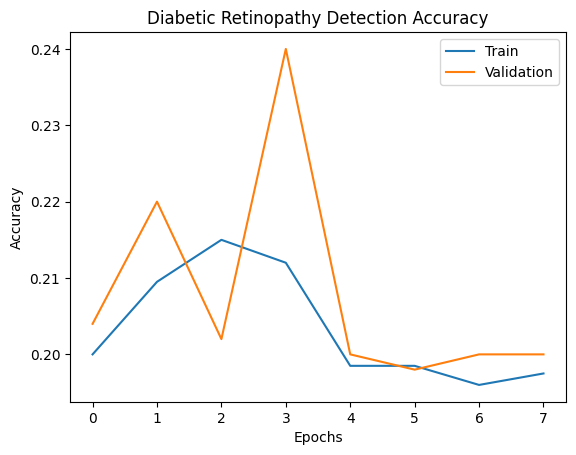

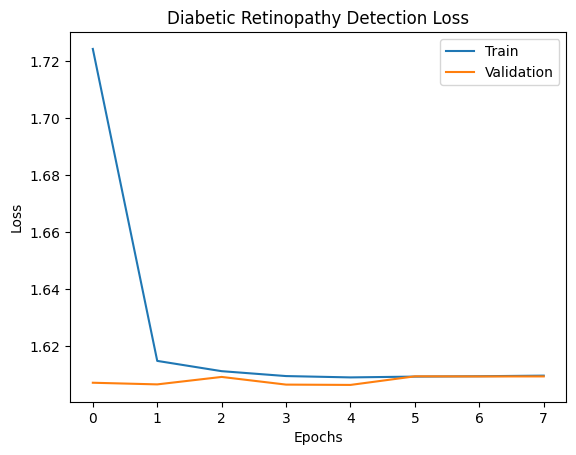

In [31]:
plt.plot(vgghistory.history['acc'])
plt.plot(vgghistory.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(vgghistory.history['loss'])
plt.plot(vgghistory.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [50]:
newHead = base.output
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dense(256, activation='relu')(newHead)
newHead = Dropout(0.2)(newHead)
newHead = Dense(128, activation='relu')(newHead)
newHead = Dropout(0.2)(newHead)
newHead = Dense(5, activation='softmax')(newHead)

vgg = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)
            
vgg.compile(loss=BinaryFocalLoss(gamma=2), optimizer=adam, metrics=['acc'])

In [52]:
vgghistory = vgg.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 117s 2s/step - loss: 0.1928 - acc: 0.3495 - val_loss: 0.1755 - val_acc: 0.4160
Epoch 2/75
63/63 [==============================] - 110s 2s/step - loss: 0.1763 - acc: 0.3920 - val_loss: 0.1756 - val_acc: 0.3820
Epoch 3/75
63/63 [==============================] - 111s 2s/step - loss: 0.1687 - acc: 0.4035 - val_loss: 0.1621 - val_acc: 0.4320
Epoch 4/75
63/63 [==============================] - 109s 2s/step - loss: 0.1589 - acc: 0.4430 - val_loss: 0.1642 - val_acc: 0.4240
Epoch 5/75
63/63 [==============================] - 115s 2s/step - loss: 0.1561 - acc: 0.4325 - val_loss: 0.1597 - val_acc: 0.4380
Epoch 6/75
63/63 [==============================] - 110s 2s/step - loss: 0.1491 - acc: 0.4880 - val_loss: 0.1564 - val_acc: 0.4560
Epoch 7/75
63/63 [==============================] - 113s 2s/step - loss: 0.1421 - acc: 0.4990 - val_loss: 0.1540 - val_acc: 0.4420
Epoch 8/75
63/63 [==============================] - 111s 2s/step - loss: 0.1358 - a

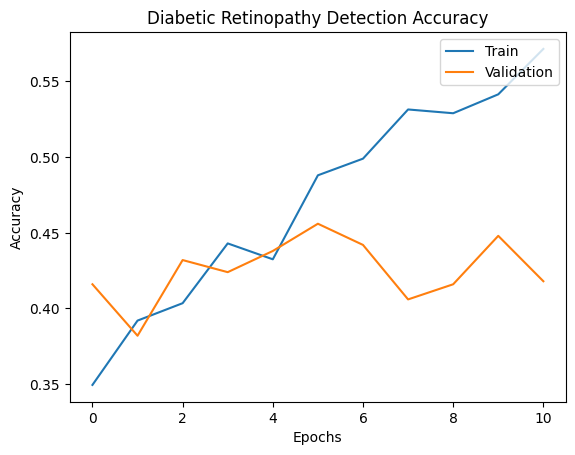

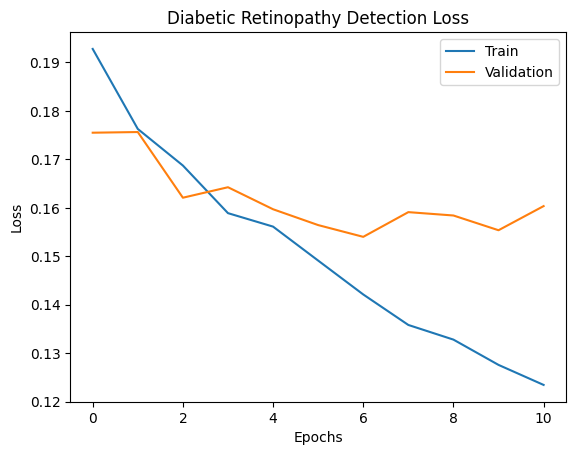

In [53]:
plt.plot(vgghistory.history['acc'])
plt.plot(vgghistory.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(vgghistory.history['loss'])
plt.plot(vgghistory.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

InceptionV3

In [13]:
from keras.applications import InceptionV3

base = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(512, 512, 3)))

base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d_6[0][0]']               
 alization)                     )                                                      

In [14]:
newHead = base.output
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dense(128, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(5, activation='softmax')(newHead)

inception = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)

            
inception.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [15]:
incH = inception.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 210s 3s/step - loss: 1.5686 - acc: 0.2960 - val_loss: 1.4253 - val_acc: 0.3780
Epoch 2/75
63/63 [==============================] - 108s 2s/step - loss: 1.4114 - acc: 0.3720 - val_loss: 1.3662 - val_acc: 0.3940
Epoch 3/75
63/63 [==============================] - 114s 2s/step - loss: 1.3757 - acc: 0.3870 - val_loss: 1.3455 - val_acc: 0.4160
Epoch 4/75
63/63 [==============================] - 118s 2s/step - loss: 1.3298 - acc: 0.4145 - val_loss: 1.3310 - val_acc: 0.4140
Epoch 5/75
63/63 [==============================] - 114s 2s/step - loss: 1.3074 - acc: 0.4310 - val_loss: 1.3143 - val_acc: 0.4360
Epoch 6/75
63/63 [==============================] - 110s 2s/step - loss: 1.2737 - acc: 0.4480 - val_loss: 1.3214 - val_acc: 0.4180
Epoch 7/75
63/63 [==============================] - 103s 2s/step - loss: 1.2406 - acc: 0.4595 - val_loss: 1.2865 - val_acc: 0.4400
Epoch 8/75
63/63 [==============================] - 106s 2s/step - loss: 1.2119 - a

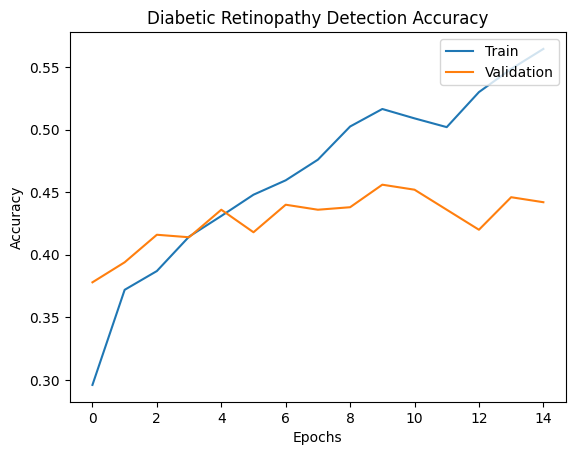

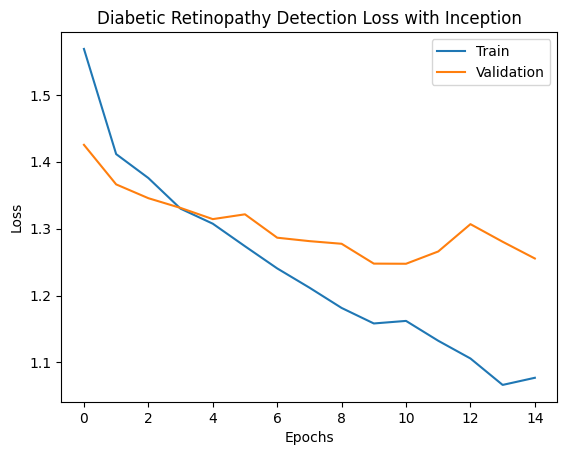

In [16]:
plt.plot(incH.history['acc'])
plt.plot(incH.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(incH.history['loss'])
plt.plot(incH.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss with Inception")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
newHead = base.output
newHead = Conv2D(30, (1, 1), activation='relu')(newHead)
newHead = Flatten()(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(256, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(64, activation='relu')(newHead)
newHead = Dense(5, activation='softmax')(newHead)

inception = Model(inputs=base.input, outputs=newHead)
inception.summary()

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)
            
inception.compile(loss=BinaryFocalLoss(gamma=2), optimizer=adam, metrics=['acc'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d_6[0][0]']               
 alization)                     )                                                           

In [18]:
incH = inception.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 134s 2s/step - loss: 0.2505 - acc: 0.2025 - val_loss: 0.2093 - val_acc: 0.2380
Epoch 2/75
63/63 [==============================] - 112s 2s/step - loss: 0.2128 - acc: 0.2615 - val_loss: 0.2075 - val_acc: 0.2600
Epoch 3/75
63/63 [==============================] - 113s 2s/step - loss: 0.2063 - acc: 0.2850 - val_loss: 0.1979 - val_acc: 0.3380
Epoch 4/75
63/63 [==============================] - 122s 2s/step - loss: 0.1947 - acc: 0.3485 - val_loss: 0.1868 - val_acc: 0.3760
Epoch 5/75
63/63 [==============================] - 123s 2s/step - loss: 0.1890 - acc: 0.3565 - val_loss: 0.1797 - val_acc: 0.3760
Epoch 6/75
63/63 [==============================] - 116s 2s/step - loss: 0.1783 - acc: 0.3790 - val_loss: 0.1744 - val_acc: 0.3880
Epoch 7/75
63/63 [==============================] - 119s 2s/step - loss: 0.1733 - acc: 0.3965 - val_loss: 0.1691 - val_acc: 0.3980
Epoch 8/75
63/63 [==============================] - 114s 2s/step - loss: 0.1666 - a

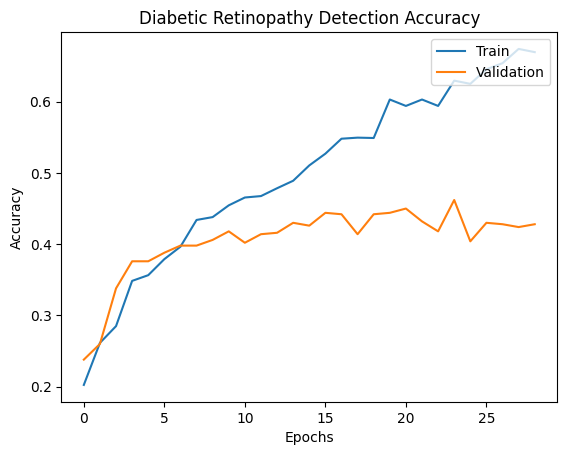

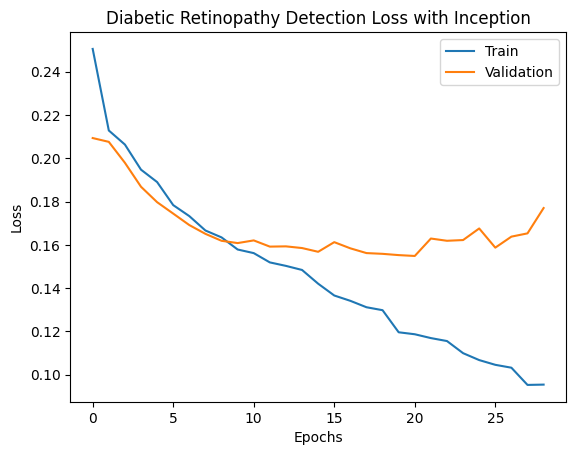

In [19]:
plt.plot(incH.history['acc'])
plt.plot(incH.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(incH.history['loss'])
plt.plot(incH.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss with Inception")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [24]:
newHead = base.output
newHead = Conv2D(30, (1, 1), activation='relu')(newHead)
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(256, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(64, activation='relu')(newHead)
newHead = Dense(5, activation='softmax')(newHead)

inception = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)
            
inception.compile(loss=BinaryFocalLoss(gamma=2), optimizer=adam, metrics=['acc'])

In [25]:
incH = inception.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 131s 2s/step - loss: 0.2255 - acc: 0.2060 - val_loss: 0.2122 - val_acc: 0.2320
Epoch 2/75
63/63 [==============================] - 120s 2s/step - loss: 0.2137 - acc: 0.2205 - val_loss: 0.2106 - val_acc: 0.2780
Epoch 3/75
63/63 [==============================] - 119s 2s/step - loss: 0.2111 - acc: 0.2450 - val_loss: 0.2085 - val_acc: 0.3340
Epoch 4/75
63/63 [==============================] - 117s 2s/step - loss: 0.2092 - acc: 0.2535 - val_loss: 0.2056 - val_acc: 0.3380
Epoch 5/75
63/63 [==============================] - 124s 2s/step - loss: 0.2059 - acc: 0.2790 - val_loss: 0.2013 - val_acc: 0.3020
Epoch 6/75
63/63 [==============================] - 120s 2s/step - loss: 0.2003 - acc: 0.2940 - val_loss: 0.1935 - val_acc: 0.3340
Epoch 7/75
63/63 [==============================] - 120s 2s/step - loss: 0.1973 - acc: 0.3125 - val_loss: 0.1930 - val_acc: 0.3080
Epoch 8/75
63/63 [==============================] - 118s 2s/step - loss: 0.1919 - a

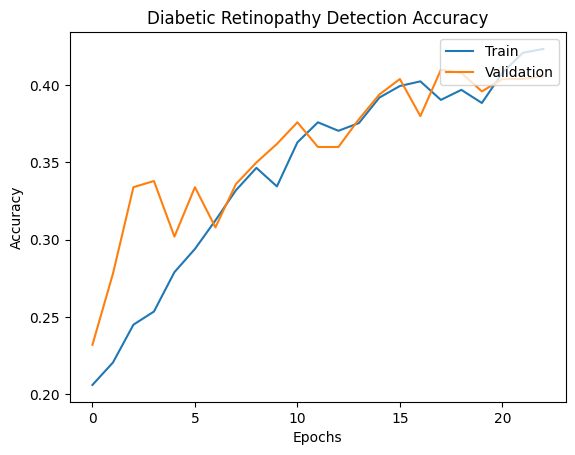

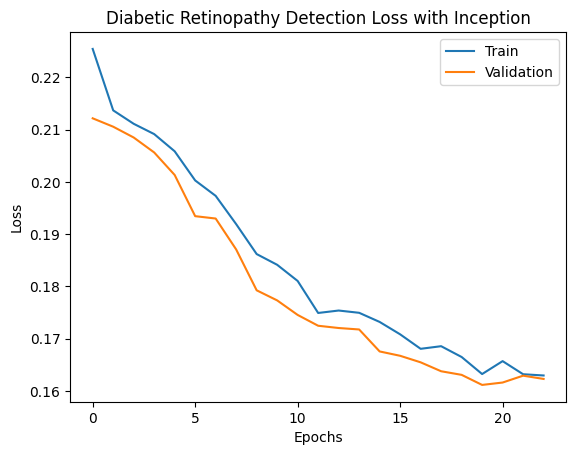

In [26]:
plt.plot(incH.history['acc'])
plt.plot(incH.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(incH.history['loss'])
plt.plot(incH.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss with Inception")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [2]:
from keras.applications import VGG19

base = VGG19(include_top=False, weights='imagenet', input_tensor=Input(shape=(512, 512, 3)))

base.summary()

NameError: name 'Input' is not defined

In [18]:
newHead = base.output
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dense(128, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(5, activation='softmax')(newHead)

vgg19 = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)

            
vgg19.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [19]:
vgg19 = vgg19.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75


Kernel crashed due to memory issues after trying to run for 8 minutes

In [10]:
from keras.applications import ResNet50

base = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(512, 512, 3)))

base.summary()

94765736/94765736 [==============================] - 9s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [12]:
newHead = base.output
newHead = AveragePooling2D(pool_size=(4, 4))(newHead)
newHead = Flatten()(newHead)
newHead = Dense(128, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(5, activation='softmax')(newHead)

resnet = Model(inputs=base.input, outputs=newHead)

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)

            
resnet.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [25]:
resnet = resnet.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 174s 2s/step - loss: 1.8073 - acc: 0.2040 - val_loss: 1.6095 - val_acc: 0.1980
Epoch 2/75
63/63 [==============================] - 113s 2s/step - loss: 1.6119 - acc: 0.1970 - val_loss: 1.6095 - val_acc: 0.1980
Epoch 3/75
63/63 [==============================] - 115s 2s/step - loss: 1.6094 - acc: 0.1940 - val_loss: 1.6095 - val_acc: 0.1980
Epoch 4/75
63/63 [==============================] - 119s 2s/step - loss: 1.6095 - acc: 0.1790 - val_loss: 1.6095 - val_acc: 0.1980
Epoch 5/75
63/63 [==============================] - 116s 2s/step - loss: 1.6094 - acc: 0.2000 - val_loss: 1.6094 - val_acc: 0.2020
Epoch 6/75
63/63 [==============================] - 114s 2s/step - loss: 1.6095 - acc: 0.1890 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 7/75
63/63 [==============================] - 114s 2s/step - loss: 1.6095 - acc: 0.1895 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 8/75
63/63 [==============================] - 112s 2s/step - loss: 1.6095 - a

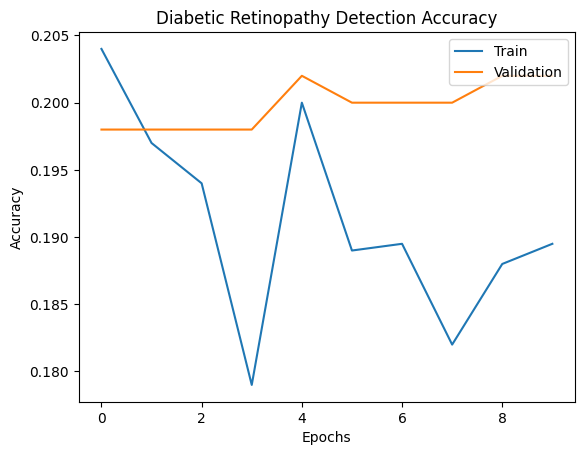

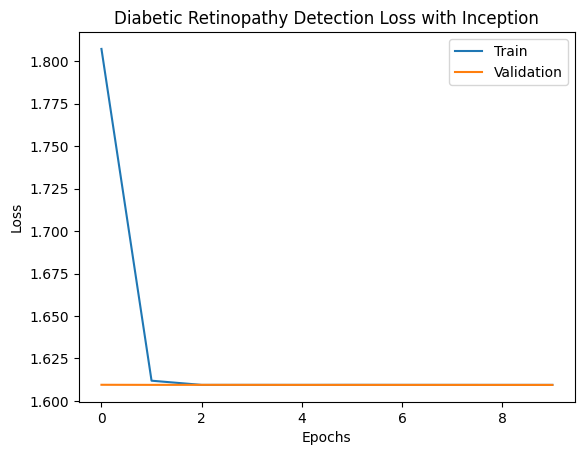

In [26]:
plt.plot(resnet.history['acc'])
plt.plot(resnet.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss with Inception")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [27]:
newHead = base.output
newHead = Conv2D(30, (1, 1), activation='relu')(newHead)
newHead = Flatten()(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(256, activation='relu')(newHead)
newHead = Dropout(0.5)(newHead)
newHead = Dense(64, activation='relu')(newHead)
newHead = Dense(5, activation='softmax')(newHead)

resnet = Model(inputs=base.input, outputs=newHead)
resnet.summary()

for layer in base.layers:
    layer.trainable = False

adam = Adam(learning_rate=1e-4)
            
resnet.compile(loss=BinaryFocalLoss(gamma=2), optimizer=adam, metrics=['acc'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [28]:
resneth = resnet.fit(train_gen, epochs=75, verbose=1, validation_data=valid_gen, callbacks=earlystop)

Epoch 1/75
63/63 [==============================] - 125s 2s/step - loss: 0.3755 - acc: 0.1820 - val_loss: 0.2143 - val_acc: 0.1860
Epoch 2/75
63/63 [==============================] - 118s 2s/step - loss: 0.2231 - acc: 0.2040 - val_loss: 0.2142 - val_acc: 0.1820
Epoch 3/75
63/63 [==============================] - 119s 2s/step - loss: 0.2187 - acc: 0.2075 - val_loss: 0.2139 - val_acc: 0.2020
Epoch 4/75
63/63 [==============================] - 116s 2s/step - loss: 0.2176 - acc: 0.2000 - val_loss: 0.2135 - val_acc: 0.2000
Epoch 5/75
63/63 [==============================] - 115s 2s/step - loss: 0.2157 - acc: 0.2085 - val_loss: 0.2134 - val_acc: 0.2000
Epoch 6/75
63/63 [==============================] - 115s 2s/step - loss: 0.2165 - acc: 0.1975 - val_loss: 0.2134 - val_acc: 0.2020
Epoch 7/75
63/63 [==============================] - 114s 2s/step - loss: 0.2147 - acc: 0.1980 - val_loss: 0.2133 - val_acc: 0.2060
Epoch 8/75
63/63 [==============================] - 115s 2s/step - loss: 0.2137 - a

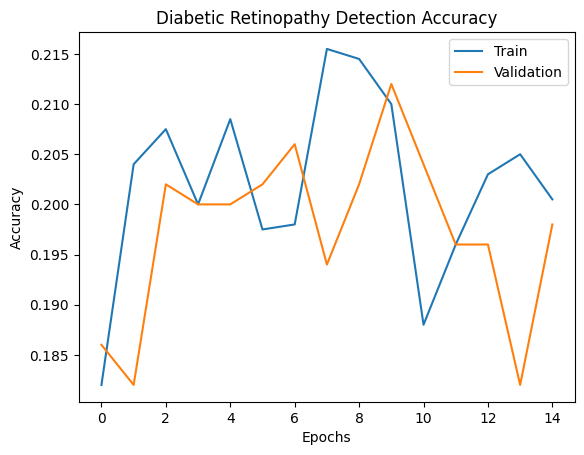

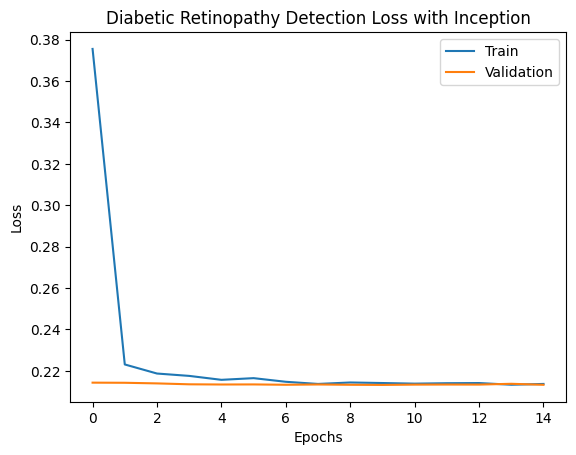

In [30]:
plt.plot(resneth.history['acc'])
plt.plot(resneth.history['val_acc'])
plt.title("Diabetic Retinopathy Detection Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(resneth.history['loss'])
plt.plot(resneth.history['val_loss'])
plt.title("Diabetic Retinopathy Detection Loss with Inception")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()